# Quantifying Accuracy/Precision of Model Parameter Values

We start with some basic, universal loading and setup.
This is the same in all how-tos and tutorials, so that there is a unified set of data to work with.

## Initial FRETBursts analysis, skip to [here](#bootstrap) to skip to how to section

> Download the example file here: [HP3_TE300_SPC630.hdf5](https://zenodo.org/record/5902313/files/HP3_TE300_SPC630.hdf5)

First let's import the necessary modules:

In [1]:
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import fretbursts as frb
import burstH2MM as bhm

# sns = frb.init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7.1).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


Load the data and search for bursts:

In [3]:
filename = 'HP3_TE300_SPC630.hdf5'
# load the data into the data object frbdata
frbdata = frb.loader.photon_hdf5(filename)

Check the alternation period etc.:

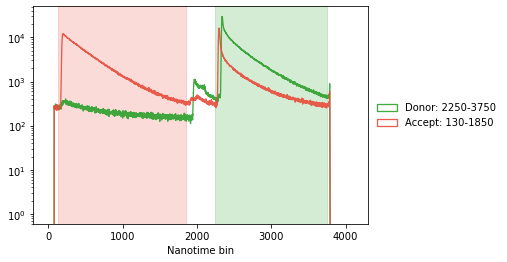

In [4]:
# plot the alternation histogram
frb.bpl.plot_alternation_hist(frbdata)

If the alternation period looks good, we can apply the alternation period to assign Donor/Acceptor excitation to each photon:

In [5]:
# if the alternation period is correct, apply data
frb.loader.alex_apply_period(frbdata)

# Total photons (after ALEX selection):    11,414,157
#  D  photons in D+A excitation periods:    5,208,392
#  A  photons in D+A excitation periods:    6,205,765
# D+A photons in  D  excitation period:     6,611,308
# D+A photons in  A  excitation period:     4,802,849



Calculate the background rates used to set thresholds for finding bursts:

 - Calculating BG rates ... get bg th arrays
Channel 0
[DONE]


<AxesSubplot:title={'center':'HP3_TE300_SPC630'}, xlabel='Inter-photon delays (ms)', ylabel='# Delays'>

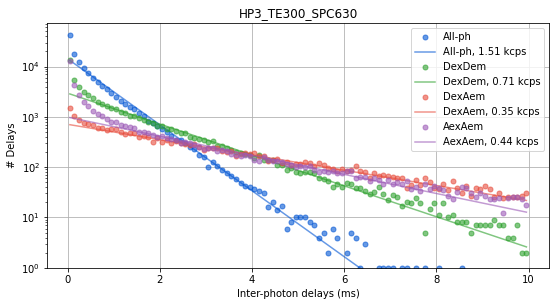

In [6]:
# calcualte the background rate
frbdata.calc_bg(frb.bg.exp_fit, F_bg=1.7)
# plot bg parameters, to verify quality
frb.dplot(frbdata, frb.hist_bg)

And finally search for bursts and refine the selection by appropriate burst size/width/other parameters:

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
<class 'matplotlib.figure.Figure'>


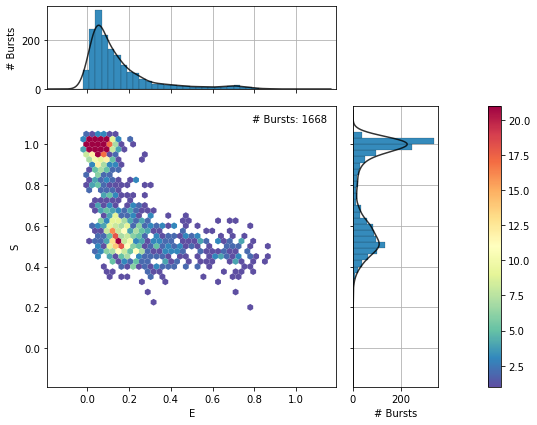

In [7]:
# now perform burst search
frbdata.burst_search(m=10, F=6)
# make sure to set the appropriate thresholds of ALL size
# parameters to the particulars of your experiment
frbdata_sel = frbdata.select_bursts(frb.select_bursts.size, th1=50)

frb.alex_jointplot(frbdata_sel);

Now that the data is selected, we can segment the photons into bursts, which will be stored in a BurstData object, and optimize the models:

In [8]:
bdata = bhm.BurstData(frbdata_sel)
# calculate models
bdata.models.calc_models(max_state=4)

The model converged after 2 iterations

The model converged after 37 iterations

The model converged after 124 iterations

The model converged after 404 iterations

2

### Examining the result

Now let's look at the ICL choosen model in the E-S plot:

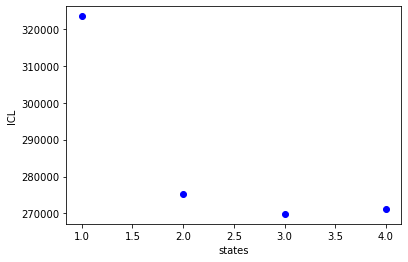

In [9]:
bhm.ICL_plot(bdata.models)

[[Text(0.41509263442653227, 0.6011142686978934, '223'),
  Text(0.41509263442653227, 0.6011142686978934, '223')],
 [Text(0.17420180061198998, 0.6303238417627565, '389'),
  Text(0.17420180061198998, 0.6303238417627565, '389')],
 [Text(0.08490190633113122, 0.8497128262415584, '901'),
  Text(0.08490190633113122, 0.8497128262415584, '901')],
 [Text(0.39531877389564074, 0.5663436713532279, '144'),
  Text(0.39531877389564074, 0.5663436713532279, '144')],
 [Text(0.41138889858048183, 0.46056143523562204, '394'),
  Text(0.41138889858048183, 0.46056143523562204, '394')],
 [Text(0.36451496387226945, 0.7077406486564151, ' 12'),
  Text(0.36451496387226945, 0.7077406486564151, ' 12')],
 [Text(0.13437614895319328, 0.6265932292189264, ' 63'),
  Text(0.13437614895319328, 0.6265932292189264, ' 63')],
 [Text(0.41840881378026706, 0.4999406275913297, '160'),
  Text(0.41840881378026706, 0.4999406275913297, '160')],
 [Text(0.122908258617842, 0.8621834792260029, '227'),
  Text(0.122908258617842, 0.862183479226

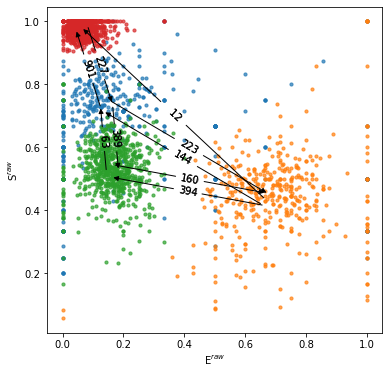

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
bhm.dwell_ES_scatter(bdata.models[3], ax=ax)
bhm.trans_arrow_ES(bdata.models[3], ax=ax)

So it looks like the 4 state model is the ideal model, so we will use it going forward

<a id='bootstrap'></a>
# Bootstrap method

Perhaps the easiest to understand method for quantifying uncertainty in a model is the bootstrap method.
In this method, the bursts are split up into $N$ subsets, and separate optimizations are run on each subset.
Then the variance of each parameter value accross the $N$ different subsets serves as a quantification of the uncertainty.

In burstH2MM, the `H2MM_result` object has the `bootstrap_eval()` function which performs this operation.

`bootstram_eval()` has one keyword argument: `subsets` by which you can specify the number of subsets to divide the data into. 
The default is 10, which is usually a good compromise.

In [11]:
bdata.models[3].bootstrap_eval(subsets=5)

The model converged after 617 iterations

The model converged after 570 iterations

The model converged after 779 iterations

The model converged after 1641 iterations

The model converged after 621 iterations

(array([[2.35305274e+02, 3.35063913e+01, 1.10219130e+02, 2.45499182e+02],
        [3.96376892e+01, 5.17865291e+01, 6.89497025e+01, 2.20406473e+01],
        [5.02425904e+01, 2.93702155e+01, 6.58887447e+01, 1.42869434e-30],
        [4.35252736e+01, 2.18804275e-14, 3.05026890e-07, 4.35252733e+01]]),
 array([[0.01057241],
        [0.02481214],
        [0.002982  ],
        [0.00207153]]),
 array([[0.03041991],
        [0.008159  ],
        [0.0063884 ],
        [0.00131442]]))

Note how the nubmer of subsets is the number of optimizations. This method automatically stores the results in the `H2MM_result.bootstrap_err` attribute, and the trans, E, and S values are also supplied as return values.

Once you run boostrap_eval, you can now access `trans_err_bs`, `E_err_bs`, `S_err_bs` attributes of `H2MM_result`. 

In [12]:
bdata.models[3].E_err_bs

array([[0.01057241],
       [0.02481214],
       [0.002982  ],
       [0.00207153]])

In [13]:
bdata.models[3].S_err_bs

array([[0.03041991],
       [0.008159  ],
       [0.0063884 ],
       [0.00131442]])

## Loglikelihood Uncertainty Evaluation

The bootstrap error is very simple, however, it also can take a long time, and the particular subsets used may have a significant influcnce on the calculated values.

## What is loglikelihood uncertainty?

The assesment of the loglikelihood uncertainties relies on finding the loglikelihood of models where one of the model parameter values has been offset from the optimal value.
While a full statistical analysis would require integration accross the whole parameter space, we note that the loglikelihoods generally distribute in a Gaussian-like manner, and therefore we can approximate the uncertainty by finding the point at which the loglikelihood is some amount less than the optimal model:

$ LL(\lambda _{\Delta E_{n}}) = LL(\lambda _{optimal}) - 0.5$

There are two points at which this is true, one where $E_{n}$ is greater than the optimal $E_{n}$, and another, where $E_{n}$ is less than the optimal $E_{n}$, denoted $E_{n, high}$ and $E_{n, low}$ respectively. 

The errors reported are thus:

$err_{LL}(E) = \frac{E_{n,high} - E_{n,low}}{2}$

Note that in most cases, $E_{n, high} - E_{n, optimal} \approx E_{n, optimal} - E_{n, low}$

This is not true however, for transition rates, and thus, in lieu of reporting an average value to represent a +/- type of error, instead we report directly the high and low transition rates.


## Calculating loglikelihood uncertianty

Estimation of Loglikelihood uncertainty is handled by `ModelError.Loglik_Error` objects, which are created automatically when a `H2MM_result` object is created, and stored in the `H2MM_result.loglik_err` attribute.
Upon its creation, no values are actually calculated, only the skeleton exists.

All parameter times (E/S/transition rates) follow the same basic rules, so we will start by demonstrating uncertainty estimation for E.

To estimate the uncertainty for E, we use the `ModelError.Loglik_Error.get_E_err()` method.


In [14]:
E_err = bdata.models[3].loglik_err.get_E_err(2)

These value indicate the point at which a models where a given parameter value is varied from the optimal, have a loglikelihood 0.5 less than the optimal model, ie:

$ LL(\lambda _{\Delta E_{n}}) = LL(\lambda _{optimal}) - 0.5$

There are two points at which this is true, one where $E_{n}$ is greater than the optimal $E_{n}$, and another, where $E_{n}$ is less than the optimal $E_{n}$, denoted $E_{n, high}$ and $E_{n, low}$ respectively. 

The errors reported are thus:

$err_{LL}(E) = \frac{E_{n,high} - E_{n,low}}{2}$

Note that in most cases, $E_{n, high} - E_{n, optimal} \approx E_{n, optimal} - E_{n, low}$

This is not true however, for transition rates, and thus, in lieu of reporting an average value to represent a +/- type of error, instead we report directly the high and low transition rates.

## Plotting parameter variance (MLE)<sup>1</sup>

It is also possible to plot how the loglikelihood varies along a given parameter.

This uses the `ll_E_scatter()`, `ll_S_scatter()` and `ll_trans_scatter()` functions.
These functions take as required arguments a `H2MM_result` object, and which state to plot. For `ll_E_scatter()` and `ll_S_scatter`, this is a single integer, indicating the index of the state. For `ll_trans_scatter()` this is two arguments: `from_state` and `to_state`.

In [15]:
bdata.models[3].loglik_err.get_trans_err(slice(None), slice(None))
bdata.models[3].trans_err_low_ll

masked_array(
  data=[[--, 194.53035171793312, 352.1205554725216, 852.0137119477389],
        [123.55769314398876, --, 365.90169681909276, 2.3667958592199523],
        [53.20295841601293, 147.33309090197375, --, 0.0],
        [214.1620775004149, 0.0, 0.0, --]],
  mask=[[ True, False, False, False],
        [False,  True, False, False],
        [False, False,  True, False],
        [False, False, False,  True]],
  fill_value=1e+20)

In [16]:
bdata.models[3].E_err_ll

masked_array(data=[--, --, 0.002187500000000009, --],
             mask=[ True,  True, False,  True],
       fill_value=1e+20)

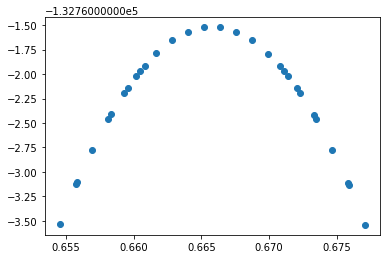

In [17]:
bhm.ll_E_scatter(bdata.models[3],1)

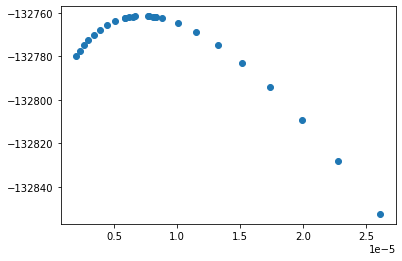

In [18]:
bhm.ll_trans_scatter(bdata.models[3], 1,0)

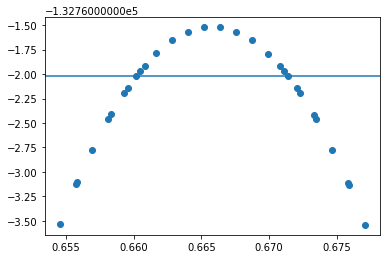

In [19]:
bhm.ll_E_scatter(bdata.models[3],1)
plt.axhline(bdata.models[3].loglik-0.5)

## Extending variance along a parameter